In [ ]:
!rm -rf /content/NF-UQ-NIDS-V2

In [ ]:
!unzip /content/drive/MyDrive/Dis-Data/NF-UQ-NIDS-V2.zip -d /content/

Archive:  /content/drive/MyDrive/Dis-Data/NF-UQ-NIDS-V2.zip
   creating: /content/NF-UQ-NIDS-V2/
  inflating: /content/NF-UQ-NIDS-V2/bag-info.txt  
  inflating: /content/NF-UQ-NIDS-V2/bagit.txt  
   creating: /content/NF-UQ-NIDS-V2/data/
  inflating: /content/NF-UQ-NIDS-V2/data/NetFlow_v2_Features.csv  
  inflating: /content/NF-UQ-NIDS-V2/data/NF-UQ-NIDS-v2.csv  
  inflating: /content/NF-UQ-NIDS-V2/FurtherInformation.txt  
  inflating: /content/NF-UQ-NIDS-V2/manifest-sha1.txt  
  inflating: /content/NF-UQ-NIDS-V2/tagmanifest-sha1.txt  


#1. DataExploration


In [31]:
import pandas as pd
import gc
import numpy as np

In [32]:
class config:
    chunksize = 200000
    file_path = '/content/NF-UQ-NIDS-V2_Sample-2.csv'

In [33]:
class DataProcessor:
    def __init__(self, file_path, chunksize=config.chunksize):
        self.file_path = file_path
        self.chunksize = chunksize
        self.reader = pd.read_csv(self.file_path, chunksize=self.chunksize, iterator=True)

    def read_next_chunk(self):
        try:
            return self.reader.get_chunk()
        except StopIteration:
            return None

    def read_in_chunks(self):
        for chunk in pd.read_csv(self.file_path, chunksize=self.chunksize):
            yield chunk

    def process_chunks_with_callback(self, callback_function):
        while True:
            try:
                chunk = self.reader.get_chunk()
                callback_function(chunk)  # Execute the callback on the chunk
                del chunk  # Delete the chunk from memory
                gc.collect()  # Explicitly trigger garbage collection
            except StopIteration:
                break

    def reset_reader(self):
        self.reader = pd.read_csv(self.file_path, chunksize=self.chunksize, iterator=True)

In [34]:
data_processor = DataProcessor(config.file_path)

#1. Data Exploration

In [35]:
class DatasetInfo:
    def __init__(self):
        self.total_rows = 0
        self.rows_with_nulls = pd.DataFrame()
        self.unique_values_Dataset = set()
        self.unique_values_Attack = set()


    def process_chunk(self, chunk):
        self.total_rows += len(chunk)
        rows_with_null_in_chunk = chunk[chunk.isnull().any(axis=1)]
        self.rows_with_nulls = pd.concat([self.rows_with_nulls, rows_with_null_in_chunk])
        self.unique_values_Dataset.update(chunk['Dataset'].unique())
        self.unique_values_Attack.update(chunk['Attack'].unique())


In [36]:
dataset_info = DatasetInfo()

data_processor.process_chunks_with_callback(dataset_info.process_chunk)

In [37]:
print("Total Rows:", dataset_info.total_rows)
print("Number of Rows with Nulls:", len(dataset_info.rows_with_nulls))
print("Number of unique datasets: ", len(dataset_info.unique_values_Dataset))
print("Unique Dataset values:", dataset_info.unique_values_Dataset)
print("Number of unique attack types: ", len(dataset_info.unique_values_Attack))
print("Unique Attack values:", dataset_info.unique_values_Attack)


Total Rows: 3799399
Number of Rows with Nulls: 0
Number of unique datasets:  4
Unique Dataset values: {'NF-UNSW-NB15-v2', 'NF-CSE-CIC-IDS2018-v2', 'NF-ToN-IoT-v2', 'NF-BoT-IoT-v2'}
Number of unique attack types:  21
Unique Attack values: {'Reconnaissance', 'Shellcode', 'Benign', 'ransomware', 'Theft', 'xss', 'Exploits', 'DoS', 'Backdoor', 'Bot', 'Infilteration', 'injection', 'Brute Force', 'DDoS', 'Generic', 'Fuzzers', 'Analysis', 'Worms', 'mitm', 'password', 'scanning'}


In [38]:
data_processor.reset_reader()
df1 = data_processor.read_next_chunk()
if df1 is not None:
  print(df1.columns)

Index(['IPV4_SRC_ADDR', 'L4_SRC_PORT', 'IPV4_DST_ADDR', 'L4_DST_PORT',
       'PROTOCOL', 'L7_PROTO', 'IN_BYTES', 'IN_PKTS', 'OUT_BYTES', 'OUT_PKTS',
       'TCP_FLAGS', 'CLIENT_TCP_FLAGS', 'SERVER_TCP_FLAGS',
       'FLOW_DURATION_MILLISECONDS', 'DURATION_IN', 'DURATION_OUT', 'MIN_TTL',
       'MAX_TTL', 'LONGEST_FLOW_PKT', 'SHORTEST_FLOW_PKT', 'MIN_IP_PKT_LEN',
       'MAX_IP_PKT_LEN', 'SRC_TO_DST_SECOND_BYTES', 'DST_TO_SRC_SECOND_BYTES',
       'RETRANSMITTED_IN_BYTES', 'RETRANSMITTED_IN_PKTS',
       'RETRANSMITTED_OUT_BYTES', 'RETRANSMITTED_OUT_PKTS',
       'SRC_TO_DST_AVG_THROUGHPUT', 'DST_TO_SRC_AVG_THROUGHPUT',
       'NUM_PKTS_UP_TO_128_BYTES', 'NUM_PKTS_128_TO_256_BYTES',
       'NUM_PKTS_256_TO_512_BYTES', 'NUM_PKTS_512_TO_1024_BYTES',
       'NUM_PKTS_1024_TO_1514_BYTES', 'TCP_WIN_MAX_IN', 'TCP_WIN_MAX_OUT',
       'ICMP_TYPE', 'ICMP_IPV4_TYPE', 'DNS_QUERY_ID', 'DNS_QUERY_TYPE',
       'DNS_TTL_ANSWER', 'FTP_COMMAND_RET_CODE', 'Label', 'Attack', 'Dataset',
       'Attack_C

In [39]:
print(df1.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 200000 entries, 0 to 199999
Data columns (total 47 columns):
 #   Column                       Non-Null Count   Dtype  
---  ------                       --------------   -----  
 0   IPV4_SRC_ADDR                200000 non-null  object 
 1   L4_SRC_PORT                  200000 non-null  int64  
 2   IPV4_DST_ADDR                200000 non-null  object 
 3   L4_DST_PORT                  200000 non-null  int64  
 4   PROTOCOL                     200000 non-null  int64  
 5   L7_PROTO                     200000 non-null  float64
 6   IN_BYTES                     200000 non-null  int64  
 7   IN_PKTS                      200000 non-null  int64  
 8   OUT_BYTES                    200000 non-null  int64  
 9   OUT_PKTS                     200000 non-null  int64  
 10  TCP_FLAGS                    200000 non-null  int64  
 11  CLIENT_TCP_FLAGS             200000 non-null  int64  
 12  SERVER_TCP_FLAGS             200000 non-null  int64  
 13 

In [40]:
print(df1.head())

     IPV4_SRC_ADDR  L4_SRC_PORT  IPV4_DST_ADDR  L4_DST_PORT  PROTOCOL  \
0  192.168.100.148        65389  192.168.100.7           80         6   
1  192.168.100.148        11154  192.168.100.5           80         6   
2     192.168.1.31        42062   192.168.1.79         1041         6   
3     192.168.1.34        46849   192.168.1.79         9110         6   
4     192.168.1.30        50360  192.168.1.152         1084         6   

   L7_PROTO  IN_BYTES  IN_PKTS  OUT_BYTES  OUT_PKTS  ...  ICMP_TYPE  \
0       7.0       420        3          0         0  ...      35840   
1       7.0       280        2         40         1  ...          0   
2       0.0        44        1         40         1  ...          0   
3       0.0        44        1         40         1  ...          0   
4       0.0        44        1         40         1  ...          0   

   ICMP_IPV4_TYPE  DNS_QUERY_ID  DNS_QUERY_TYPE  DNS_TTL_ANSWER  \
0             140             0               0               0   


In [41]:
from sklearn.preprocessing import LabelEncoder
LE = LabelEncoder()
srcaddr= LE.fit_transform(df1['IPV4_SRC_ADDR'])
df1['IPV4_SRC_ADDR'] = pd.Series(srcaddr)
dstaddr= LE.fit_transform(df1['IPV4_DST_ADDR'])
df1['IPV4_DST_ADDR'] = pd.Series(dstaddr)

In [42]:
X = df1.drop(['Attack','Label','Dataset','Attack_Class'], axis=1)
Y = df1["Label"]

In [43]:
from sklearn.impute import SimpleImputer
imputer = SimpleImputer(missing_values = np.nan, strategy = 'mean')

X_object = X.select_dtypes("object")
X_int = X.select_dtypes(exclude = "object")

X_columns = X_int.columns

imputer.fit(X_int)
X_int = imputer.transform(X_int)
X_int = pd.DataFrame(X_int)
X_int.columns = X_columns

X_object = X_object.fillna("unknown")
X = X_object.join(X_int)

In [44]:
import matplotlib.pyplot as plt
import seaborn as sns

In [45]:
import matplotlib.font_manager as fm

# Clear the font cache
fm._get_fontconfig_fonts.cache_clear()


# Update the font cache
fm.findSystemFonts(fontpaths=None, fontext='ttf')

# Optionally, set the font family
import matplotlib.pyplot as plt
plt.rcParams['font.family'] = 'DejaVu Serif'

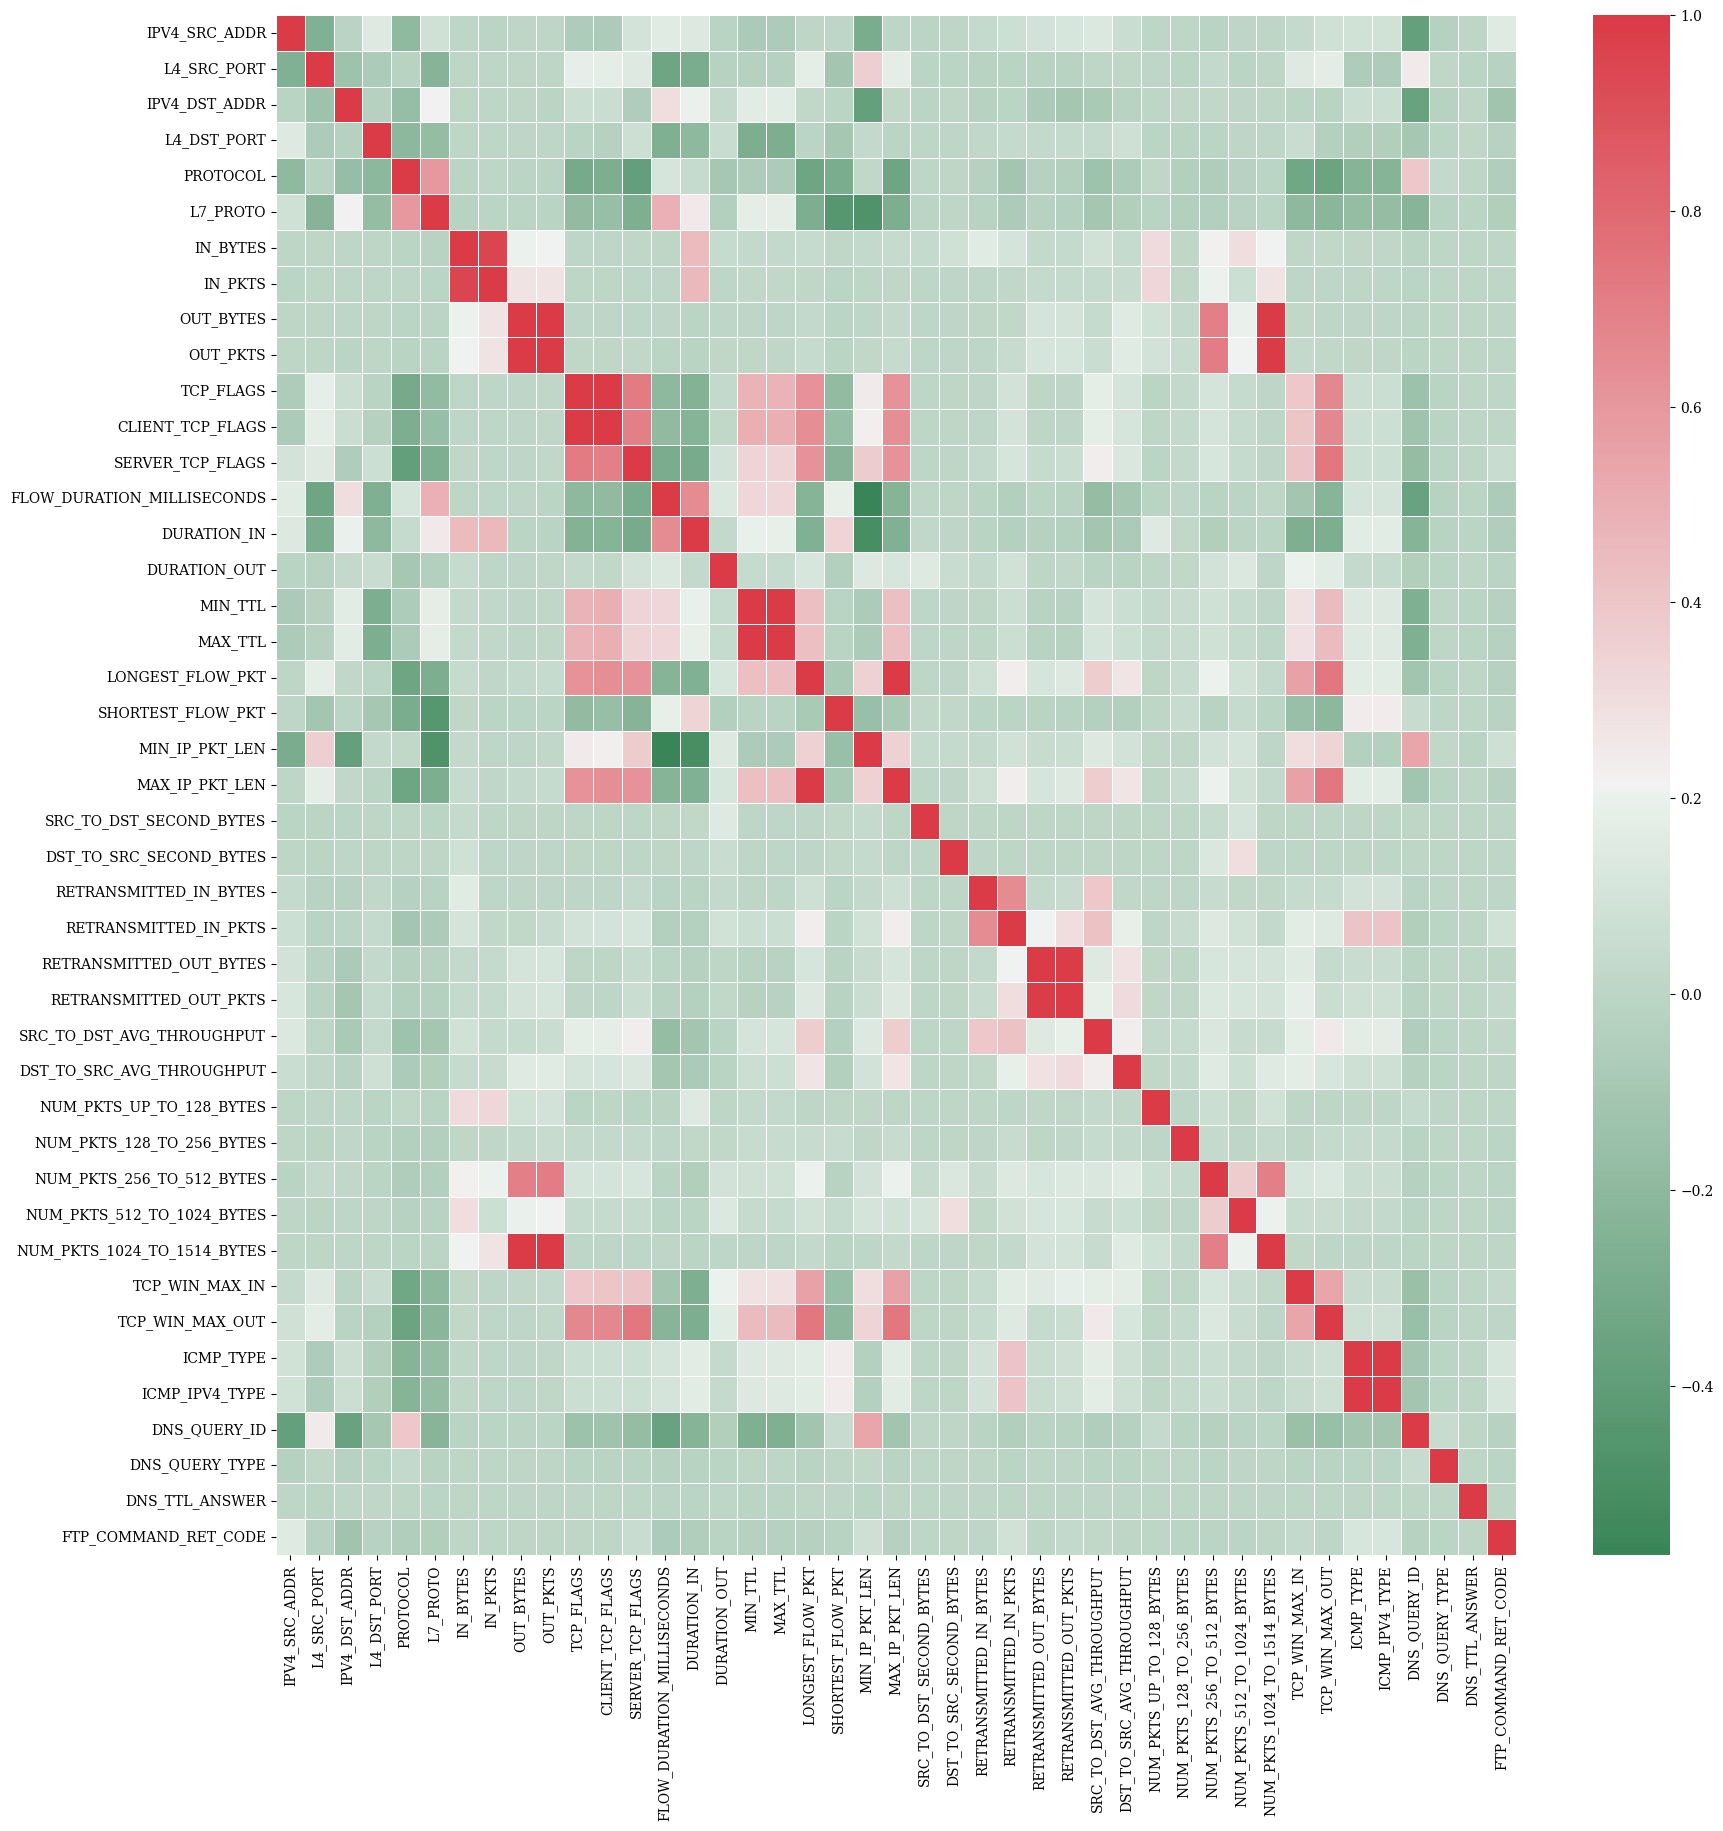

In [46]:
plt.figure(figsize = (20,20))
cmap = sns.diverging_palette(500, 10, as_cmap=True)
attrb_reln = sns.heatmap(X.corr(),linewidths=0.5, cmap=cmap)
plt.savefig('correlations_dataset.jpg', dpi=1000)

In [47]:
corr_with_target = X.corrwith(Y).apply(abs)
df_corr_w_tgt = pd.DataFrame(corr_with_target)
df_corr_w_tgt.to_csv('Feature_Corr_w_Target.csv')

In [48]:
class LabelEncoderExt(object):
    def __init__(self):
        self.label_encoder = LabelEncoder()

    def fit(self, data):
        self.label_encoder = self.label_encoder.fit(list(data) + ['Unknown'])
        self.classes_ = self.label_encoder.classes_
        return self

    def transform(self, data):
        new_data = list(data)
        for unique_item in np.unique(data):
            if unique_item not in self.label_encoder.classes_:
                new_data = ['Unknown' if x==unique_item else x for x in new_data]
        return self.label_encoder.transform(new_data)

In [49]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, Y, test_size=0.3, random_state=42)

In [50]:
from sklearn.preprocessing import StandardScaler, MinMaxScaler
scaler = MinMaxScaler()
# store the columns
cols = X_train.columns

# transform the data
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

X_train_scaled = pd.DataFrame(X_train_scaled, columns = cols)
X_test_scaled = pd.DataFrame(X_test_scaled, columns = cols)

In [51]:
from sklearn.ensemble import RandomForestClassifier
rfc = RandomForestClassifier();

rfc.fit(X_train_scaled, y_train)

feature_imp = pd.DataFrame({'Importance':rfc.feature_importances_,'feature':X_train.columns})
feature_imp = feature_imp.sort_values('Importance',ascending=False).set_index('feature')

In [52]:
import matplotlib.pyplot as plt

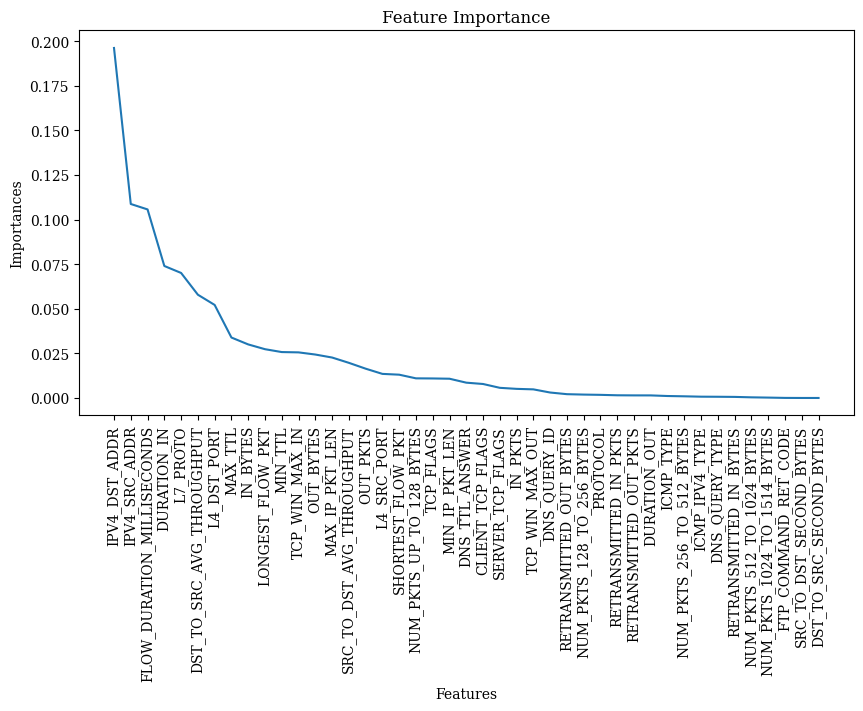

In [53]:
plt.figure(figsize = (10, 5))
plt.title("Feature Importance")
plt.ylabel("Importances")
plt.xlabel("Features")
plt.xticks(rotation=90)
plt.plot(feature_imp)
plt.savefig('feature_importance.jpg', bbox_inches='tight' , dpi=900)

In [54]:
X_train_scaled

,IPV4_SRC_ADDR,L4_SRC_PORT,IPV4_DST_ADDR,L4_DST_PORT,PROTOCOL,L7_PROTO,IN_BYTES,IN_PKTS,OUT_BYTES,OUT_PKTS,...,NUM_PKTS_512_TO_1024_BYTES,NUM_PKTS_1024_TO_1514_BYTES,TCP_WIN_MAX_IN,TCP_WIN_MAX_OUT,ICMP_TYPE,ICMP_IPV4_TYPE,DNS_QUERY_ID,DNS_QUERY_TYPE,DNS_TTL_ANSWER,FTP_COMMAND_RET_CODE
0,0.524775,0.003983,0.359113,0.001221,0.063492,0.767347,0.000012,0.000018,0.000000,0.000000,...,0.0,0.0,0.000000,0.0,0.00000,0.00000,0.000000,0.000000,0.000000,0.0
1,0.303116,0.784848,0.173693,0.000809,0.063492,0.000000,0.000010,0.000000,0.000003,0.000042,...,0.0,0.0,0.000000,0.0,0.00000,0.00000,0.759191,0.000031,0.000099,0.0
2,0.521021,0.006760,0.354041,0.694826,0.019841,0.371429,0.000007,0.000000,0.000000,0.000000,...,0.0,0.0,0.003464,0.0,0.00000,0.00000,0.000000,0.000000,0.000000,0.0
3,0.525338,0.718624,0.359113,0.434636,0.019841,0.000000,0.000006,0.000000,0.000001,0.000042,...,0.0,0.0,0.015625,0.0,0.00000,0.00000,0.000000,0.000000,0.000000,0.0
4,0.525338,0.467155,0.360063,0.001221,0.063492,0.767347,0.000008,0.000009,0.000000,0.000000,...,0.0,0.0,0.000000,0.0,0.00000,0.00000,0.000000,0.000000,0.000000,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
139995,0.524962,0.294484,0.359746,0.001221,0.019841,0.028571,0.000043,0.000009,0.000000,0.000000,...,0.0,0.0,0.007813,0.0,0.00000,0.00000,0.000000,0.000000,0.000000,0.0
139996,0.254692,0.796216,0.173693,0.000809,0.063492,0.000000,0.000008,0.000000,0.000002,0.000042,...,0.0,0.0,0.000000,0.0,0.00000,0.00000,0.758595,0.000031,0.000099,0.0
139997,0.380443,0.777279,0.221236,0.029054,0.019841,0.000000,0.000006,0.000000,0.000000,0.000000,...,0.0,0.0,0.015625,0.0,0.00000,0.00000,0.000000,0.000000,0.000000,0.0
139998,0.522335,0.617975,0.352139,0.992126,0.019841,0.000000,0.000007,0.000000,0.000001,0.000042,...,0.0,0.0,0.062501,0.0,0.00000,0.00000,0.000000,0.000000,0.000000,0.0


In [55]:
from sklearn.feature_selection import RFE
estimator = RandomForestClassifier()
selector = RFE(estimator)
selector.fit(X_train_scaled, y_train)

X_train_scaled = selector.transform(X_train_scaled)
X_test_scaled = selector.transform(X_test_scaled)

In [57]:
len(X_train_scaled[1])

21

#2. DataPreprocessing

In [58]:
%matplotlib inline

In [59]:
# prompt: Check null /Nan values in dataset


map the attack-types to groups to reduce the number of types

In [ ]:
mapping = {
            'Benign': 'Benign',
            'DoS': 'DoS',
            'DDoS': 'DDoS',
            'scanning': 'Phishing',
            'Reconnaissance':'Phishing',
            'xss': 'XSS',
            'password': 'Password',
            'injection': 'SQL Injection',
            'Bot': 'Botnet',
            'Brute Force': 'Brute Force',
            'Infilteration': 'Phishing',
            'Exploits': 'Zero Day Exploit',
            'Fuzzers': 'Phishing',
            'Backdoor': 'Malware',
            'Generic': 'Malware',
            'mitm': 'MITM',
            'ransomware': 'Malware',
            'Analysis': 'Phishing',
            'Theft': 'Phishing',
            'Shellcode': 'Zero Day Exploit',
            'Worms': 'Malware',
           }
df['Attack_Class'] = df['Attack'].apply(lambda v: mapping[v])
#network = df.drop('Attack', axis = 1)
df.head(5)

In [ ]:
attack_class_division = df[['Attack_Class']].apply(lambda t: t.value_counts())
attack_class_division['Frequency'] = np.round((attack_class_division / attack_class_division.sum()) * 100, 2)
attack_table = pd.concat([attack_class_division], axis=1)
attack_table

In [ ]:
plt.bar(attack_table.index, attack_table['Attack_Class'], color='darkblue')
plt.xlabel("Class", fontweight="bold")
plt.ylabel("Attack Numbers")
plt.title("The Number In Each Network Attack Type", fontfamily="elephant",
          fontweight="bold")
plt.xticks(rotation=60, fontsize=10)
plt.figure(figsize=(1000, 120))
plt.show()

In [ ]:
plt.figure(figsize=(11, 11))
explode =(0, 0, 0,0, 0.1, 0.2, 0.8, 1.0, 1.6, 1.8, 2.0)
plt.pie(attack_table['Frequency'], labels=attack_table.index,
        autopct="%1.2f%%", explode=explode, shadow=True, radius = 1, startangle=60)
plt.title("The Distribution of Each Network Attack As a Percentage", fontsize = 20,
          fontweight="bold",
          x = 0.2, y = 1.1)
plt.legend(loc= 'lower right', bbox_to_anchor=(0, 0, 1.2, 0.1))
plt.show()

In [ ]:
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import LabelEncoder

scaler = StandardScaler()
scaler_columns_names = df.select_dtypes(include=['float64', 'int64']).columns
scaler_columns_satisfied = scaler.fit_transform(df.select_dtypes(include=['float64', 'int64']))
numeric_model = pd.DataFrame(scaler_columns_satisfied, columns=scaler_columns_names)

encoder = LabelEncoder()
encoder_column_names = df.select_dtypes(include=['object']).copy()
encoder_columns_satisfied = encoder_column_names.apply(encoder.fit_transform)
encoder_columns_satisfied_without_labels = encoder_columns_satisfied.drop(['Attack_Class'], axis=1)
labels_referenced = df[['Attack_Class']].copy()

train_X = pd.concat([numeric_model, encoder_columns_satisfied_without_labels], axis=1)
train_y = labels_referenced
train_X

In [ ]:
from sklearn.ensemble import RandomForestClassifier
rfc = RandomForestClassifier()
rfc.fit(train_X, train_y)

scores = np.round(rfc.feature_importances_, 3)
scores_table = pd.DataFrame({'features': train_X.columns, 'scores': scores})
scores_table = scores_table.sort_values(by='scores', ascending=False).set_index('features')

plt.bar(scores_table.index, scores_table['scores'], color="darkgreen", label="scores")
plt.xlabel("Features")
plt.ylabel("Scores")
plt.title("Which Features Should Be Selected?",  fontsize=20,
          fontweight="bold", fontstyle="italic")
plt.xticks(rotation=90, fontsize=6)
plt.legend(loc='upper right')
plt.figure(figsize=(11, 4))
plt.show()

In [ ]:
# prompt: print all the rows where the IPV4_SRC_ADDR or IPV4_DST_ADDR is not of the format xxx.xxx.xxx.xxx

import re

def is_valid_ipv4(ip_address):
  """Checks if an IP address is in the format xxx.xxx.xxx.xxx."""
  pattern = r"^\d{1,3}\.\d{1,3}\.\d{1,3}\.\d{1,3}$"
  return bool(re.match(pattern, ip_address))

# Find rows where IPV4_SRC_ADDR or IPV4_DST_ADDR is not in the correct format
invalid_rows = df[~df['IPV4_SRC_ADDR'].apply(lambda x: isinstance(x, str) and is_valid_ipv4(x)) |
                 ~df['IPV4_DST_ADDR'].apply(lambda x: isinstance(x, str) and is_valid_ipv4(x))]

print(invalid_rows)


In [ ]:
# prompt: write code to drop the invalid rows

df = df.drop(invalid_rows.index)


In [ ]:
def convert_IPV4_to_num(obj):
    partitions = obj.split('.')
    if len(partitions) == 4:
        l = [np.int64(x) for x in partitions]
        return l[0] * np.power(256, 3) + l[1] * np.power(256, 2) + l[2] * np.power(256, 1) + l[3] * np.power(256, 0)
    else:
        print(obj)
        #Handle invalid IP addresses (e.g., return 0 or raise an error)
        return 0 # or raise ValueError("Invalid IP address")

In [ ]:
df['IPV4_SRC_ADDR'] = df['IPV4_SRC_ADDR'].apply(convert_IPV4_to_num)
df['IPV4_DST_ADDR'] = df['IPV4_DST_ADDR'].apply(convert_IPV4_to_num)

In [ ]:
# prompt: labelencode attact_class

from sklearn.preprocessing import LabelEncoder

# Assuming 'Attack_Class' is the column you want to label encode
le = LabelEncoder()
df['Attack_Class_LE'] = le.fit_transform(df['Attack_Class'])
